PREDICTING RECOVERED AND WRITTEN OFF, THEN FROM UNDER RECOVERED PREDICT FULLY AND PARTIALLY RECOVERED



It will be divided into steps ;

---Step 1; predict recovered (1) and written off (0)


---Step 2; Predict Fully recovered(1) and partial recovered (0)





In [1]:
#IMPORT LIBRARIES
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, accuracy_score,classification_report
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn import tree
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split

import matplotlib.pyplot as plt
import graphviz
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
import numpy as np

from sklearn.preprocessing import LabelEncoder

Step 1  recovered and Written off

In [2]:
import pandas as pd

lr=pd.read_csv('loan-recovery.csv')
lr.info()

#change to categories all columns object which has less than 5 records
for col in lr.columns:
  if lr[col].dtype == 'object' and lr[col].nunique() < 5:
    lr[col] = lr[col].astype('category')
lr.info()

#creating a new column from Recovery status change  partially recovered and fully recovered to 1 and written off as 0
lr['isrecovered'] = [0 if a == 'Written Off' else 1 for a in lr['Recovery_Status']]
lr.info()

# Apply one-hot encoding to categorical columns except the target
dummy_cols = [col for col in lr.columns if lr[col].dtype.name == 'category' and col != 'Recovery_Status']
lr = pd.get_dummies(lr, columns=dummy_cols, drop_first=True)
lr.info()

print(lr['isrecovered'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Borrower_ID              500 non-null    object 
 1   Age                      500 non-null    int64  
 2   Gender                   500 non-null    object 
 3   Employment_Type          500 non-null    object 
 4   Monthly_Income           500 non-null    int64  
 5   Num_Dependents           500 non-null    int64  
 6   Loan_ID                  500 non-null    object 
 7   Loan_Amount              500 non-null    int64  
 8   Loan_Tenure              500 non-null    int64  
 9   Interest_Rate            500 non-null    float64
 10  Loan_Type                500 non-null    object 
 11  Collateral_Value         500 non-null    float64
 12  Outstanding_Loan_Amount  500 non-null    float64
 13  Monthly_EMI              500 non-null    float64
 14  Payment_History          5

In [3]:

X1 = lr.drop(['Loan_ID', 'Borrower_ID', 'Recovery_Status', 'isrecovered'], axis=1, errors='ignore')
y1 = lr['isrecovered']

In [4]:
# Split data into training and validation sets
X1_train, X1_val, y1_train, y1_val = train_test_split(X1, y1, test_size=0.4, random_state=42)

print(f"Shape of training features: {X1_train.shape}")
print(f"Shape of validation features: {X1_val.shape}")
print(f"Shape of training target: {y1_train.shape}")
print(f"Shape of validation target: {y1_val.shape}")

# BALANCE THE TRAIN DATA SET BY OVER SAMPLING

# Instantiate RandomOverSampler
from collections import Counter
ros = RandomOverSampler(random_state=42)

# Resample the training data
X_train_resampled, y_train_resampled = ros.fit_resample(X1_train, y1_train)

# Print class distribution before and after oversampling
print("Class distribution before oversampling:", Counter(y1_train))
print("Class distribution after oversampling:", Counter(y_train_resampled))

print("Training set shape after oversampling (X_train_resampled, y_train_resampled):", X_train_resampled.shape, y_train_resampled.shape)

Shape of training features: (300, 24)
Shape of validation features: (200, 24)
Shape of training target: (300,)
Shape of validation target: (200,)
Class distribution before oversampling: Counter({1: 272, 0: 28})
Class distribution after oversampling: Counter({1: 272, 0: 272})
Training set shape after oversampling (X_train_resampled, y_train_resampled): (544, 24) (544,)


In [5]:
# A MAXIMAL TREE WITH THE  ROC AND F1 SCORE RESULT

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.tree import plot_tree
from sklearn.metrics import  classification_report
# Create a maximal Decision Tree model
# We don't set any max_depth or min_samples_split to allow the tree to grow fully
dt_model_maximal = DecisionTreeClassifier(random_state=42)

# Train the maximal tree model on the resampled training data
max_model =dt_model_maximal.fit(X_train_resampled, y_train_resampled)

# Predict on the validation set
y_pred_valid_maximal = max_model.predict(X1_val)
y_pred_train_resampled = max_model.predict(X_train_resampled)

# Calculate accuracy
accuracy = accuracy_score(y_pred_valid_maximal,y1_val )
print("Accuracy:", round(accuracy, 2))
accuracy_train = accuracy_score( y_pred_train_resampled,y_train_resampled,)
roc_auc= roc_auc_score(y1_val, y_pred_valid_maximal)

print(f"ROC AUC: {roc_auc:.4f}")

print("Accuracy train:", round(accuracy_train, 2))
# Classification report
print("Classification Report:")
print(classification_report(y1_val, y_pred_valid_maximal))
print(f"Maximal Decision Tree Results on Validation Set:")
print("Classification Report train:")
print(classification_report(y_train_resampled, y_pred_train_resampled))


Accuracy: 0.92
ROC AUC: 0.7331
Accuracy train: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.50      0.56        22
           1       0.94      0.97      0.95       178

    accuracy                           0.92       200
   macro avg       0.79      0.73      0.76       200
weighted avg       0.91      0.92      0.91       200

Maximal Decision Tree Results on Validation Set:
Classification Report train:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       272
           1       1.00      1.00      1.00       272

    accuracy                           1.00       544
   macro avg       1.00      1.00      1.00       544
weighted avg       1.00      1.00      1.00       544



Grid Search

In [6]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1,)

# Fit the model
grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate on test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X1_val)
accuracy_dt = accuracy_score(y1_val, y_pred)
print(f"\nDecision Tree Accuracy: {accuracy_dt:.4f}")


print("\nClassification Report:\n", classification_report(y1_val, y_pred))
print("accuracy:",accuracy_score(y1_val, y_pred))
print("ROC AUC:", roc_auc_score(y1_val, y_pred))



Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}

Decision Tree Accuracy: 0.9150

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.50      0.56        22
           1       0.94      0.97      0.95       178

    accuracy                           0.92       200
   macro avg       0.79      0.73      0.76       200
weighted avg       0.91      0.92      0.91       200

accuracy: 0.915
ROC AUC: 0.7331460674157304


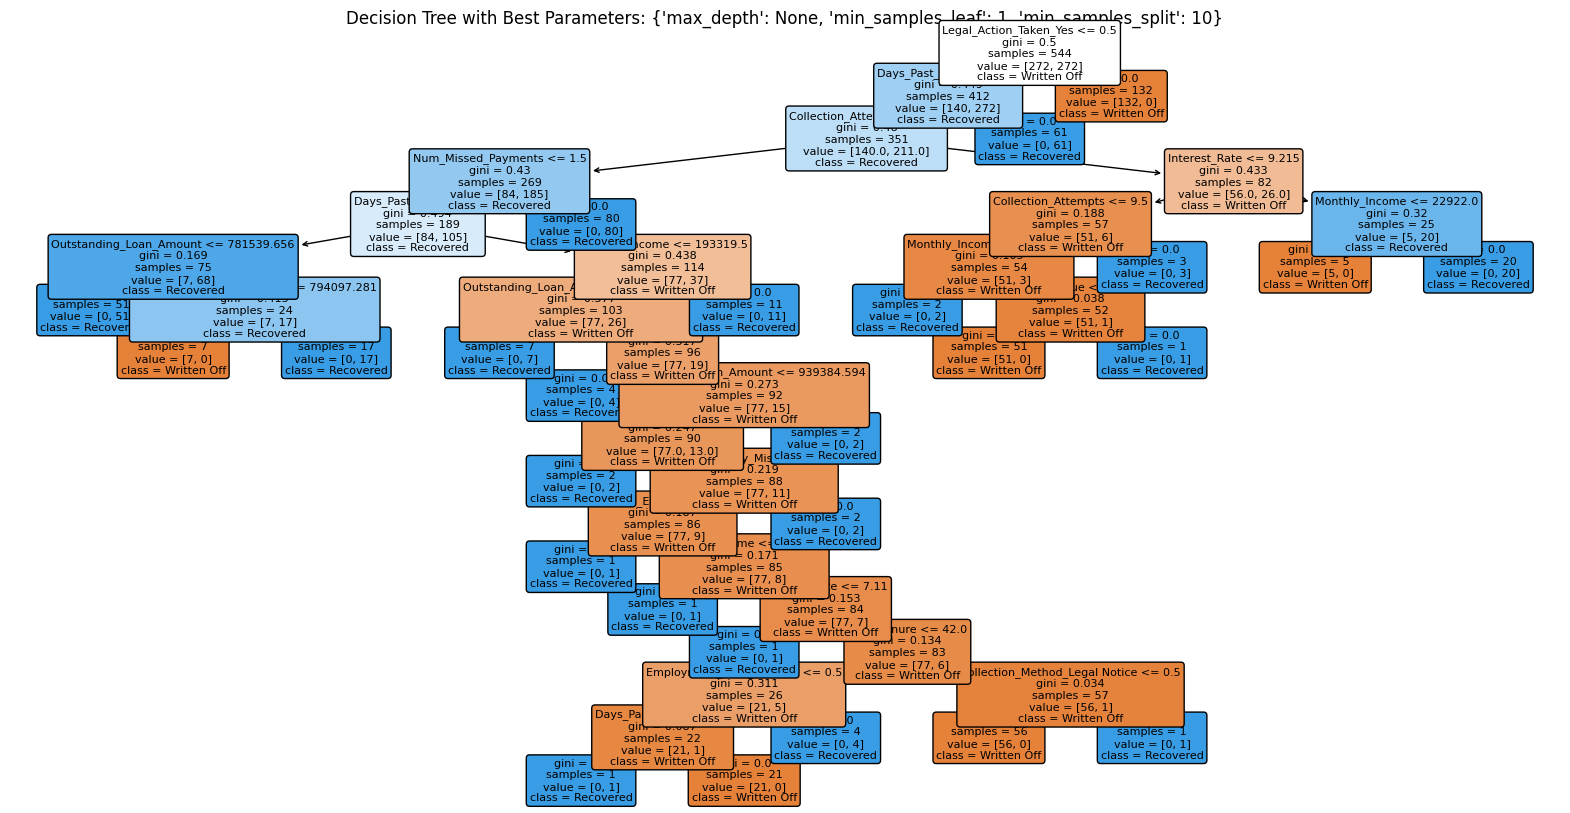

In [7]:
# visualise the tree of best parameter of the grid search

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Visualize the tree with the best parameters
plt.figure(figsize=(20, 10))
plot_tree(best_model, feature_names=X1.columns.tolist(), class_names=['Written Off', 'Recovered'], filled=True, rounded=True, fontsize=8)
plt.title(f"Decision Tree with Best Parameters: {grid_search.best_params_}")
plt.show()

Random Forest

                               feature  importance       std
18              Payment_History_Missed    0.004414  0.010295
20   Collection_Method_Debt Collectors    0.005825  0.011472
13            Employment_Type_Salaried    0.006922  0.011658
15                  Loan_Type_Business    0.007162  0.015760
17                  Loan_Type_Personal    0.007666  0.014612
14       Employment_Type_Self-Employed    0.007780  0.013634
16                      Loan_Type_Home    0.007994  0.015602
22  Collection_Method_Settlement Offer    0.008464  0.015612
19             Payment_History_On-Time    0.011303  0.017647
21      Collection_Method_Legal Notice    0.013084  0.017303
2                       Num_Dependents    0.022367  0.025312
4                          Loan_Tenure    0.025359  0.026932
12                         Gender_Male    0.031288  0.029945
9                  Num_Missed_Payments    0.044408  0.041207
6                     Collateral_Value    0.048612  0.043948
0                       

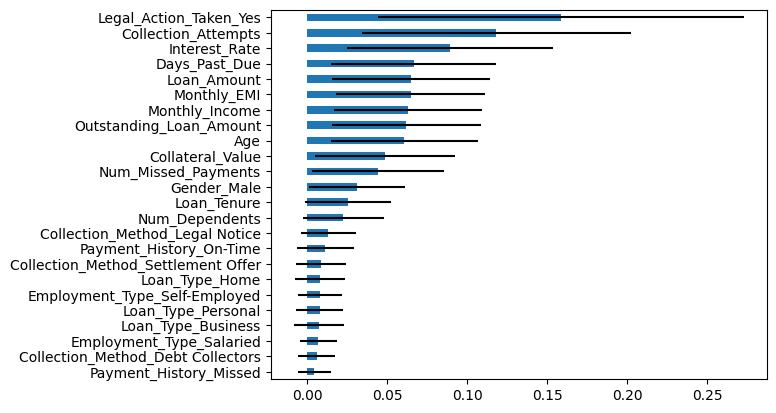

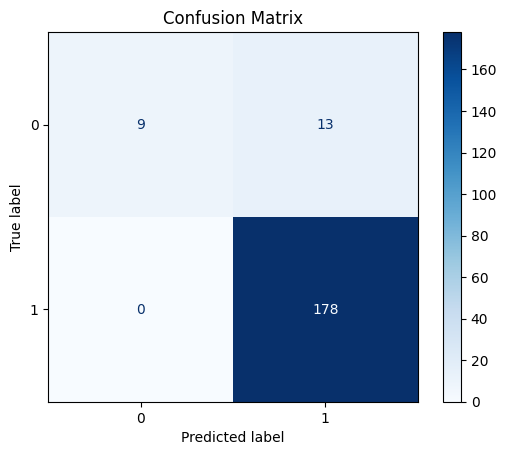


Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.41      0.58        22
           1       0.93      1.00      0.96       178

    accuracy                           0.94       200
   macro avg       0.97      0.70      0.77       200
weighted avg       0.94      0.94      0.92       200

accuracy: 0.935
ROC AUC: 0.7045454545454546


In [8]:
rf = RandomForestClassifier(random_state=1, n_estimators=500)
best_rf=rf.fit(X_train_resampled, y_train_resampled)
y_pred = best_rf.predict(X1_val)

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

df = pd.DataFrame({'feature': X1.columns, 'importance': importances, 'std': std})
df = df.sort_values('importance')
print(df)

ax = df.plot(kind='barh', xerr='std', x='feature', legend=False)
ax.set_ylabel('')

# Confusion matrix
cm = confusion_matrix(y1_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y1_val, y_pred))
print("accuracy:",accuracy_score(y1_val, y_pred))
print("ROC AUC:", roc_auc_score(y1_val, y_pred))

regression with importance feature from random forest

In [9]:
lr=pd.read_csv('loan-recovery.csv')


for col in lr.columns:
  if lr[col].dtype == 'object' and lr[col].nunique() < 5:
    lr[col] = lr[col].astype('category')
columns_to_cap_floor = ['Monthly_EMI', 'Num_Missed_Payments', 'Collateral_Value','Collection_Attempts']

for col_name in columns_to_cap_floor:

    Q1 = lr[col_name].quantile(0.25)
    Q3 = lr[col_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Apply floor and cap
    lr[col_name] = np.where(lr[col_name] < lower_bound, lower_bound, lr[col_name])
    lr[col_name] = np.where(lr[col_name] > upper_bound, upper_bound, lr[col_name])

# Prepare data for the first stage: Recovered vs. Written Off
lr_stage1 = lr.copy()
lr_stage1['isrecovered'] = lr_stage1['Recovery_Status'].apply(lambda x: 'Recovered' if x in ['Fully Recovered', 'Partially Recovered'] else 'Written Off')

# Feature Engineering for Stage 1 - One-hot encode categorical columns
lr_stage1 = pd.get_dummies(lr_stage1, columns=['Gender', 'Employment_Type', 'Loan_Type', 'Payment_History', 'Collection_Method', 'Legal_Action_Taken'], drop_first=True)

X1 = lr_stage1.drop(['Loan_ID', 'Borrower_ID', 'Recovery_Status', 'isrecovered'], axis=1, errors='ignore')
y1 = lr_stage1['isrecovered']

Splitting of data

In [10]:
# Split data into training and validation sets
X1_train, X1_val, y1_train, y1_val = train_test_split(X1, y1, test_size=0.4, random_state=42)

print(f"Shape of training features: {X1_train.shape}")
print(f"Shape of validation features: {X1_val.shape}")
print(f"Shape of training target: {y1_train.shape}")
print(f"Shape of validation target: {y1_val.shape}")



# Instantiate RandomOverSampler
from collections import Counter
ros = RandomOverSampler(random_state=42)

# Resample the training data
X1_train_resampled, y1_train_resampled = ros.fit_resample(X1_train, y1_train)

# Print class distribution before and after oversampling
print("Class distribution before oversampling:", Counter(y1_train))
print("Class distribution after oversampling:", Counter(y1_train_resampled))

print("Training set shape after oversampling (X1_train_resampled, y1_train_resampled):", X1_train_resampled.shape, y1_train_resampled.shape)

Shape of training features: (300, 24)
Shape of validation features: (200, 24)
Shape of training target: (300,)
Shape of validation target: (200,)
Class distribution before oversampling: Counter({'Recovered': 272, 'Written Off': 28})
Class distribution after oversampling: Counter({'Recovered': 272, 'Written Off': 272})
Training set shape after oversampling (X1_train_resampled, y1_train_resampled): (544, 24) (544,)


In [11]:
#FORWARD REGRESSION step 1

forward_selector = SFS(LogisticRegression(max_iter=1000, solver='liblinear'),
                       k_features='best', forward=True, floating=False, scoring='roc_auc', cv=5)

forward_selector = forward_selector.fit(X1_train_resampled, y1_train_resampled)
selected_forward = list(forward_selector.k_feature_names_)
print("Forward selected features:", selected_forward)


model_fwd1 = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42 ,class_weight= 'balanced')
model_fwd1.fit(X1_train_resampled[selected_forward], y1_train_resampled)
y1_prob_fwd = model_fwd1.predict_proba(X1_val[selected_forward])[:, 1]
y1_pred_fwd = model_fwd1.predict(X1_val[selected_forward])

 # Evaluate Stage 1 model
from sklearn.metrics import roc_auc_score
roc_auc1= roc_auc_score(y1_val, y1_prob_fwd)
accuracy1 = accuracy_score(y1_val, y1_pred_fwd)
report1 = classification_report(y1_val, y1_pred_fwd)
print("\nStage 1 (Recovered vs. written off) Results:")
print(f"ROC AUC: {roc_auc1:.4f}")
print(f"Accuracy: {accuracy1:.4f}")
print("Classification Report:")

report2 = classification_report(y1_val, y1_pred_fwd)
print(report2)

Forward selected features: ['Age', 'Num_Dependents', 'Monthly_EMI', 'Num_Missed_Payments', 'Collection_Attempts', 'Gender_Male', 'Loan_Type_Business', 'Loan_Type_Home', 'Loan_Type_Personal', 'Payment_History_On-Time', 'Collection_Method_Settlement Offer', 'Legal_Action_Taken_Yes']

Stage 1 (Recovered vs. written off) Results:
ROC AUC: 0.7377
Accuracy: 0.8250
Classification Report:
              precision    recall  f1-score   support

   Recovered       0.94      0.86      0.90       178
 Written Off       0.32      0.55      0.41        22

    accuracy                           0.82       200
   macro avg       0.63      0.70      0.65       200
weighted avg       0.87      0.82      0.84       200



In [12]:
#BACKWARD REGRESSION step1

backward_selector = SFS(LogisticRegression(max_iter=1000, solver='liblinear'),
                       k_features='best', forward=False, floating=False, scoring='roc_auc', cv=5)

backward_selector = backward_selector.fit(X1_train_resampled, y1_train_resampled)
selected_backward = list(backward_selector.k_feature_names_)
print("Backward selected features:", selected_backward)


model_bwd1 = LogisticRegression(max_iter=1000, solver='liblinear',class_weight= 'balanced', random_state = 42)
model_bwd1.fit(X1_train_resampled[selected_backward], y1_train_resampled)
y1_prob_bwd = model_bwd1.predict_proba(X1_val[selected_backward])[:, 1]
y1_pred_bwd = model_bwd1.predict(X1_val[selected_backward])

 # Evaluate Stage 1 model
roc_auc1 = roc_auc_score(y1_val, y1_prob_bwd)
accuracy1 = accuracy_score(y1_val, y1_pred_bwd)
report1 = classification_report(y1_val, y1_pred_bwd)
print("\nStage 1 ( Recovered vs. written off) Results:")
print(f"ROC AUC: {roc_auc1:.4f}")
print(f"Accuracy: {accuracy1:.4f}")
print("Classification Report:")

report1 = classification_report(y1_val, y1_pred_bwd)
print(report1)

Backward selected features: ['Num_Dependents', 'Num_Missed_Payments', 'Collection_Attempts', 'Gender_Male', 'Employment_Type_Salaried', 'Loan_Type_Business', 'Loan_Type_Home', 'Loan_Type_Personal', 'Payment_History_On-Time', 'Collection_Method_Debt Collectors', 'Collection_Method_Settlement Offer', 'Legal_Action_Taken_Yes']

Stage 1 ( Recovered vs. written off) Results:
ROC AUC: 0.7480
Accuracy: 0.8350
Classification Report:
              precision    recall  f1-score   support

   Recovered       0.93      0.88      0.90       178
 Written Off       0.33      0.50      0.40        22

    accuracy                           0.83       200
   macro avg       0.63      0.69      0.65       200
weighted avg       0.87      0.83      0.85       200



In [13]:
#STEPWISE REGRESSION

stepwise_selector = SFS(LogisticRegression(max_iter=1000, solver='liblinear'), k_features='best', forward=True, floating=True, scoring='roc_auc', cv=5)

stepwise_selector = stepwise_selector.fit(X1_train_resampled, y1_train_resampled)
selected_stepwise = list(stepwise_selector.k_feature_names_)
print("Stepwise selected features:", selected_stepwise)

model_step1= LogisticRegression(max_iter=1000, solver='liblinear',class_weight='balanced', random_state = 42)
model_step1.fit(X1_train_resampled[selected_stepwise], y1_train_resampled)
y1_prob_step = model_step1.predict_proba(X1_val[selected_stepwise])[:, 1]
y1_pred_step = model_step1.predict(X1_val[selected_stepwise])

 # Evaluate Stage 1 model
roc_auc1 = roc_auc_score(y1_val, y1_prob_step)
accuracy1 = accuracy_score(y1_val, y1_pred_step)
report1 = classification_report(y1_val, y1_pred_step)
print("\nStage 1(Recovered vs. written off) Results:")
print(f"ROC AUC: {roc_auc1:.4f}")
print(f"Accuracy: {accuracy1:.4f}")
print("Classification Report:")

report2 = classification_report(y1_val, y1_pred_step)
print(report2)



Stepwise selected features: ['Num_Dependents', 'Num_Missed_Payments', 'Days_Past_Due', 'Collection_Attempts', 'Gender_Male', 'Employment_Type_Salaried', 'Loan_Type_Business', 'Loan_Type_Home', 'Loan_Type_Personal', 'Payment_History_On-Time', 'Collection_Method_Debt Collectors', 'Collection_Method_Legal Notice', 'Collection_Method_Settlement Offer', 'Legal_Action_Taken_Yes']

Stage 1(Recovered vs. written off) Results:
ROC AUC: 0.7474
Accuracy: 0.8300
Classification Report:
              precision    recall  f1-score   support

   Recovered       0.93      0.88      0.90       178
 Written Off       0.31      0.45      0.37        22

    accuracy                           0.83       200
   macro avg       0.62      0.67      0.64       200
weighted avg       0.86      0.83      0.84       200



regression without correlated features

In [38]:
lr=pd.read_csv('loan-recovery.csv')


for col in lr.columns:
  if lr[col].dtype == 'object' and lr[col].nunique() < 5:
    lr[col] = lr[col].astype('category')
columns_to_cap_floor = ['Monthly_EMI', 'Num_Missed_Payments', 'Collateral_Value','Collection_Attempts']

for col_name in columns_to_cap_floor:

# fixing skewness
    Q1 = lr[col_name].quantile(0.25)
    Q3 = lr[col_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Apply floor and cap
    lr[col_name] = np.where(lr[col_name] < lower_bound, lower_bound, lr[col_name])
    lr[col_name] = np.where(lr[col_name] > upper_bound, upper_bound, lr[col_name])

# Prepare data for the first stage: Recovered vs. Written Off
stage1_lr = lr.copy()
stage1_lr['isrecovered'] = lr_stage1['Recovery_Status'].apply(lambda x: 'Recovered' if x in ['Fully Recovered', 'Partially Recovered'] else 'Written Off')


# Feature Engineering for Stage 1 - One-hot encode categorical columns
stage1_lr = pd.get_dummies(stage1_lr, columns=['Gender', 'Employment_Type', 'Loan_Type', 'Payment_History', 'Legal_Action_Taken'], drop_first=True)

In [39]:
X1 = stage1_lr.drop(['Recovery_Status','Loan_ID','Borrower_ID','isrecovered', 'Loan_Amount', 'Collection_Method'], axis=1)
y1= stage1_lr['isrecovered']



In [40]:

# Split data into training and validation sets
X1_train, X1_val, y1_train, y1_val = train_test_split(X1, y1, test_size=0.4, random_state=42)

print(f"Shape of training features: {X1_train.shape}")
print(f"Shape of validation features: {X1_val.shape}")
print(f"Shape of training target: {y1_train.shape}")
print(f"Shape of validation target: {y1_val.shape}")



# Instantiate RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Resample the training data
X1_train_resampled, y1_train_resampled = ros.fit_resample(X1_train, y1_train)

# Print class distribution before and after oversampling
print("Class distribution before oversampling:", Counter(y1_train))
print("Class distribution after oversampling:", Counter(y1_train_resampled))

print("Training set shape after oversampling (X1_train_resampled, y1_train_resampled):", X1_train_resampled.shape, y1_train_resampled.shape)

Shape of training features: (300, 20)
Shape of validation features: (200, 20)
Shape of training target: (300,)
Shape of validation target: (200,)
Class distribution before oversampling: Counter({'Recovered': 272, 'Written Off': 28})
Class distribution after oversampling: Counter({'Recovered': 272, 'Written Off': 272})
Training set shape after oversampling (X1_train_resampled, y1_train_resampled): (544, 20) (544,)


In [42]:
#FORWARD REGRESSION step 1

forward_selector = SFS(LogisticRegression(max_iter=1000, solver='liblinear'),
                       k_features='best', forward=True, floating=False, scoring='roc_auc', cv=5)

forward_selector = forward_selector.fit(X1_train_resampled, y1_train_resampled)
selected_forward = list(forward_selector.k_feature_names_)
print("Forward selected features:", selected_forward)


model_fwd1 = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42 ,class_weight= 'balanced')
model_fwd1.fit(X1_train_resampled[selected_forward], y1_train_resampled)
y1_prob_fwd = model_fwd1.predict_proba(X1_val[selected_forward])[:, 1]
y1_pred_fwd = model_fwd1.predict(X1_val[selected_forward])

 # Evaluate Stage 1 model
roc_auc1= roc_auc_score(y1_val, y1_prob_fwd)
accuracy1 = accuracy_score(y1_val, y1_pred_fwd)
report1 = classification_report(y1_val, y1_pred_fwd)
print("\nStage 1 (Recovered vs. written off) Results:")
print(f"ROC AUC: {roc_auc1:.4f}")
print(f"Accuracy: {accuracy1:.4f}")
print("Classification Report:")

report2 = classification_report(y1_val, y1_pred_fwd)
print(report2)


Forward selected features: ['Num_Dependents', 'Monthly_EMI', 'Num_Missed_Payments', 'Days_Past_Due', 'Collection_Attempts', 'Gender_Male', 'Employment_Type_Salaried', 'Employment_Type_Self-Employed', 'Loan_Type_Business', 'Loan_Type_Home', 'Loan_Type_Personal', 'Payment_History_On-Time', 'Legal_Action_Taken_Yes']

Stage 1 (Recovered vs. written off) Results:
ROC AUC: 0.7612
Accuracy: 0.8450
Classification Report:
              precision    recall  f1-score   support

   Recovered       0.95      0.88      0.91       178
 Written Off       0.37      0.59      0.46        22

    accuracy                           0.84       200
   macro avg       0.66      0.73      0.68       200
weighted avg       0.88      0.84      0.86       200



In [43]:
#the odds ratio of the above forward regression as it is the best model
import statsmodels.api as sm # Import statsmodels.api

X1_train_fwd = X1_train_resampled[selected_forward].copy() # Make a copy to avoid modifying the original DataFrame
# Convert boolean columns to integers
for col in X1_train_fwd.columns:
    if X1_train_fwd[col].dtype == 'bool':
       X1_train_fwd[col] = X1_train_fwd[col].astype(int)

# Convert target variable to integer
y1_train_resampled_numeric = y1_train_resampled.map({'Recovered': 1, 'Written Off': 0}).astype(int)

X1_train_fwd = sm.add_constant(X1_train_fwd, prepend=False)


logit_model_fwd = sm.Logit(y1_train_resampled_numeric, X1_train_fwd)
result_fwd = logit_model_fwd.fit()

print(result_fwd.summary())

# Calculate Odds Ratios
odds_ratios_bwd = pd.DataFrame({
    'Odds Ratio': np.exp(result_fwd.params),
    'Conf. Int. (2.5%)': np.exp(result_fwd.conf_int()[0]),
    'Conf. Int. (97.5%)': np.exp(result_fwd.conf_int()[1])
})

print("\nOdds Ratios for Backward Regression:")
odds_ratios_bwd

         Current function value: 0.366491
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:            isrecovered   No. Observations:                  544
Model:                          Logit   Df Residuals:                      530
Method:                           MLE   Df Model:                           13
Date:                Mon, 04 Aug 2025   Pseudo R-squ.:                  0.4713
Time:                        14:44:36   Log-Likelihood:                -199.37
converged:                      False   LL-Null:                       -377.07
Covariance Type:            nonrobust   LLR p-value:                 5.663e-68
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Num_Dependents                    0.2574      0.112      2.299      0.021       0.038       0.477
Monthly_

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Odds Ratio,Conf. Int. (2.5%),Conf. Int. (97.5%)
Num_Dependents,1.293545e+00,1.038706,1.610907
Monthly_EMI,1.000012e+00,0.999987,1.000037
Num_Missed_Payments,1.940079e+00,1.431956,2.628508
Days_Past_Due,9.980580e-01,0.992700,1.003445
Collection_Attempts,8.550725e-01,0.779774,0.937642
Gender_Male,2.417570e-01,0.126801,0.460930
Employment_Type_Salaried,1.784468e+00,0.793455,4.013241
Employment_Type_Self-Employed,1.009403e+00,0.430521,2.366655
Loan_Type_Business,1.177026e-01,0.031743,0.436445
Loan_Type_Home,1.336916e-01,0.040999,0.435945


In [18]:
#BACKWARD REGRESSION step1

backward_selector = SFS(LogisticRegression(max_iter=1000, solver='liblinear'),
                       k_features='best', forward=False, floating=False, scoring='roc_auc', cv=5)

backward_selector = backward_selector.fit(X1_train_resampled, y1_train_resampled)
selected_backward = list(backward_selector.k_feature_names_)
print("Backward selected features:", selected_backward)


model_bwd1 = LogisticRegression(max_iter=1000, solver='liblinear',class_weight= 'balanced', random_state = 42)
model_bwd1.fit(X1_train_resampled[selected_backward], y1_train_resampled)
y1_prob_bwd = model_bwd1.predict_proba(X1_val[selected_backward])[:, 1]
y1_pred_bwd = model_bwd1.predict(X1_val[selected_backward])

 # Evaluate Stage 1 model
roc_auc1 = roc_auc_score(y1_val, y1_prob_bwd)
accuracy1 = accuracy_score(y1_val, y1_pred_bwd)
report1 = classification_report(y1_val, y1_pred_bwd)
print("\nStage 1 ( Recovered vs. written off) Results:")
print(f"ROC AUC: {roc_auc1:.4f}")
print(f"Accuracy: {accuracy1:.4f}")
print("Classification Report:")

report1 = classification_report(y1_val, y1_pred_bwd)
print(report1)

Backward selected features: ['Num_Dependents', 'Num_Missed_Payments', 'Collection_Attempts', 'Gender_Male', 'Employment_Type_Salaried', 'Employment_Type_Self-Employed', 'Loan_Type_Business', 'Loan_Type_Home', 'Loan_Type_Personal', 'Payment_History_On-Time', 'Legal_Action_Taken_Yes']

Stage 1 ( Recovered vs. written off) Results:
ROC AUC: 0.7634
Accuracy: 0.8350
Classification Report:
              precision    recall  f1-score   support

   Recovered       0.94      0.87      0.90       178
 Written Off       0.35      0.59      0.44        22

    accuracy                           0.83       200
   macro avg       0.65      0.73      0.67       200
weighted avg       0.88      0.83      0.85       200



In [20]:
#STEPWISE REGRESSION

stepwise_selector = SFS(LogisticRegression(max_iter=1000, solver='liblinear'), k_features='best', forward=True, floating=True, scoring='roc_auc', cv=5)

stepwise_selector = stepwise_selector.fit(X1_train_resampled, y1_train_resampled)
selected_stepwise = list(stepwise_selector.k_feature_names_)
print("Stepwise selected features:", selected_stepwise)

model_step1= LogisticRegression(max_iter=1000, solver='liblinear',class_weight='balanced', random_state = 42)
model_step1.fit(X1_train_resampled[selected_stepwise], y1_train_resampled)
y1_prob_step = model_step1.predict_proba(X1_val[selected_stepwise])[:, 1]
y1_pred_step = model_step1.predict(X1_val[selected_stepwise])

 # Evaluate Stage 1 model
roc_auc1 = roc_auc_score(y1_val, y1_prob_step)
accuracy1 = accuracy_score(y1_val, y1_pred_step)
report1 = classification_report(y1_val, y1_pred_step)
print("\nStage 1(Recovered vs. written off) Results:")
print(f"ROC AUC: {roc_auc1:.4f}")
print(f"Accuracy: {accuracy1:.4f}")
print("Classification Report:")

report2 = classification_report(y1_val, y1_pred_step)
print(report2)



Stepwise selected features: ['Num_Dependents', 'Num_Missed_Payments', 'Collection_Attempts', 'Gender_Male', 'Employment_Type_Salaried', 'Employment_Type_Self-Employed', 'Loan_Type_Business', 'Loan_Type_Home', 'Loan_Type_Personal', 'Payment_History_On-Time', 'Legal_Action_Taken_Yes']

Stage 1(Recovered vs. written off) Results:
ROC AUC: 0.7634
Accuracy: 0.8350
Classification Report:
              precision    recall  f1-score   support

   Recovered       0.94      0.87      0.90       178
 Written Off       0.35      0.59      0.44        22

    accuracy                           0.83       200
   macro avg       0.65      0.73      0.67       200
weighted avg       0.88      0.83      0.85       200



conclusion for step 1
the metrics precision, recall and f1 score was used for model comparison. as i dont want to get a false positive , a precisely a false prediction of recovered to avoid wasting resources, and protects the financial integrity of loan operation, my key metric is precision , which is supported by f1score and then recall. forward regression without correlated features  was the best model which peformed well.

Step 2 fully recovered and partially recovered

In [62]:
# Step 1: Map Stage 1 target - Recovered vs. Written Off
lr['isrecovered'] = lr['Recovery_Status'].map(lambda x: 1 if x in ['Fully Recovered', 'Partially Recovered'] else 0)


# Step 2: Filter only recovered loans to define Stage 2 target
stage2_lr = lr[lr['isrecovered'] == 1].copy()

# Step 3: Map Stage 2 target - Fully vs. Partially Recovered
stage2_lr['recovery_level'] = stage2_lr['Recovery_Status'].map(lambda x: 1 if x == 'Fully Recovered' else 0)

stage2_lr=pd.get_dummies(stage2_lr, columns=['Gender', 'Employment_Type', 'Loan_Type', 'Payment_History', 'Collection_Method','Legal_Action_Taken'], drop_first=True)

X2 = stage2_lr.drop(['Loan_ID', 'Borrower_ID', 'Recovery_Status','recovery_level', 'isrecovered', 'Legal_Action_Taken_Yes'], axis=1, errors='ignore')
y2 = stage2_lr['recovery_level']

In [63]:
# Split data into training and validation sets
X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2, test_size=0.4, random_state=42)

print(f"Shape of training features: {X2_train.shape}")
print(f"Shape of validation features: {X2_val.shape}")
print(f"Shape of training target: {y2_train.shape}")
print(f"Shape of validation target: {y2_val.shape}")

# BALANCE THE TRAIN DATA SET BY OVER SAMPLING

# Instantiate RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Resample the training data
X2_train_resampled, y2_train_resampled = ros.fit_resample(X2_train, y2_train)

# Print class distribution before and after oversampling
print("Class distribution before oversampling:", Counter(y2_train))
print("Class distribution after oversampling:", Counter(y2_train_resampled))

print("Training set shape after oversampling (X2_train_resampled, y2_train_resampled):", X2_train_resampled.shape, y2_train_resampled.shape)

Shape of training features: (270, 23)
Shape of validation features: (180, 23)
Shape of training target: (270,)
Shape of validation target: (180,)
Class distribution before oversampling: Counter({1: 181, 0: 89})
Class distribution after oversampling: Counter({1: 181, 0: 181})
Training set shape after oversampling (X2_train_resampled, y2_train_resampled): (362, 23) (362,)


In [64]:
# A MAXIMAL TREE WITH THE  ROC AND F1 SCORE RESULT
# Create a maximal Decision Tree model
# We don't set any max_depth or min_samples_split to allow the tree to grow fully
dt_model_maximal = DecisionTreeClassifier(random_state=42)

# Train the maximal tree model on the resampled training data
max_model =dt_model_maximal.fit(X2_train_resampled, y2_train_resampled)

# Predict on the validation set
y2_pred_valid_maximal = max_model.predict(X2_val)
y2_pred_train_resampled = max_model.predict(X2_train_resampled)

# Calculate accuracy
accuracy2 = accuracy_score(y2_pred_valid_maximal,y2_val )
print("Accuracy:", round(accuracy2, 2))
accuracy2_train = accuracy_score( y2_pred_train_resampled,y2_train_resampled,)
roc_auc2= roc_auc_score(y2_val, y2_pred_valid_maximal)

print(f"ROC AUC: {roc_auc2:.4f}")

print("Accuracy train:", round(accuracy2_train, 2))

# Classification report
print("Classification Report:")
print(classification_report(y2_val, y2_pred_valid_maximal))
print(f"Maximal Decision Tree Results on Validation Set:")
print("Classification Report train:")
print(classification_report(y2_train_resampled, y2_pred_train_resampled))


Accuracy: 0.78
ROC AUC: 0.7535
Accuracy train: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.65      0.68        65
           1       0.81      0.86      0.84       115

    accuracy                           0.78       180
   macro avg       0.77      0.75      0.76       180
weighted avg       0.78      0.78      0.78       180

Maximal Decision Tree Results on Validation Set:
Classification Report train:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       181
           1       1.00      1.00      1.00       181

    accuracy                           1.00       362
   macro avg       1.00      1.00      1.00       362
weighted avg       1.00      1.00      1.00       362



Grid search step 2

In [24]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1,)

# Fit the model
grid_search.fit(X2_train_resampled, y2_train_resampled)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate on test data
best_model = grid_search.best_estimator_
y2_pred = best_model.predict(X2_val)
accuracy_dt = accuracy_score(y2_val, y2_pred)
print(f"\nDecision Tree Accuracy: {accuracy_dt:.4f}")


print("\nClassification Report:\n", classification_report(y2_val, y2_pred))
print("ROC AUC score:", roc_auc_score(y2_val, y2_pred))


Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}

Decision Tree Accuracy: 0.7167

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.68      0.63        65
           1       0.80      0.74      0.77       115

    accuracy                           0.72       180
   macro avg       0.70      0.71      0.70       180
weighted avg       0.73      0.72      0.72       180

ROC AUC score: 0.7080267558528428


Random Forest step 2

                               feature  importance       std
23              Legal_Action_Taken_Yes    0.000000  0.000000
18              Payment_History_Missed    0.003881  0.007358
15                  Loan_Type_Business    0.005863  0.009926
22  Collection_Method_Settlement Offer    0.008619  0.012174
21      Collection_Method_Legal Notice    0.009229  0.011751
14       Employment_Type_Self-Employed    0.009514  0.012598
13            Employment_Type_Salaried    0.010004  0.012099
16                      Loan_Type_Home    0.010236  0.013128
17                  Loan_Type_Personal    0.010609  0.015057
19             Payment_History_On-Time    0.010689  0.012545
12                         Gender_Male    0.010704  0.013029
20   Collection_Method_Debt Collectors    0.010922  0.014109
2                       Num_Dependents    0.027306  0.020470
9                  Num_Missed_Payments    0.027551  0.022116
4                          Loan_Tenure    0.032904  0.024105
10                      

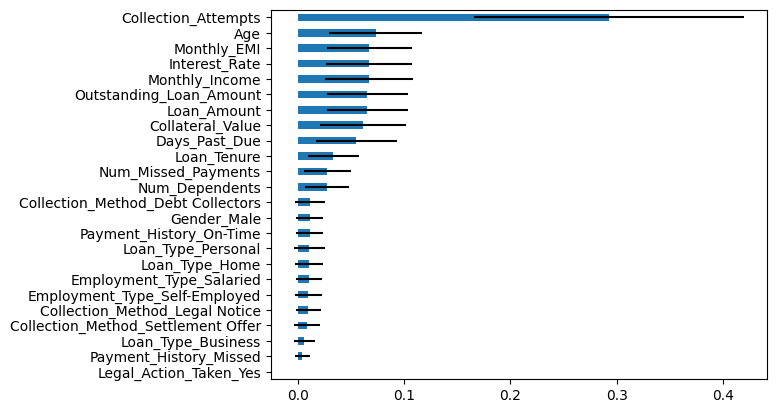

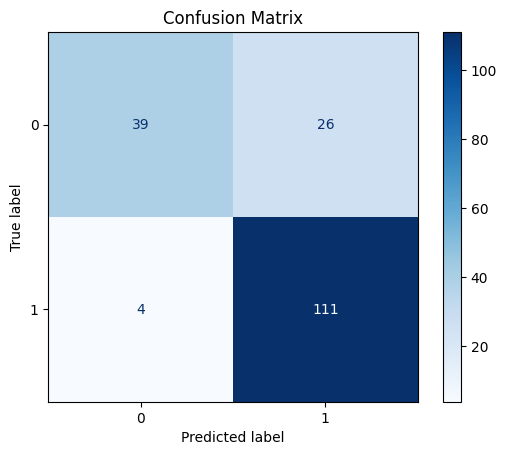


Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.60      0.72        65
           1       0.81      0.97      0.88       115

    accuracy                           0.83       180
   macro avg       0.86      0.78      0.80       180
weighted avg       0.85      0.83      0.82       180

accuracy ; 0.8333333333333334
ROC AUC score: 0.7826086956521738


In [25]:

rf2 = RandomForestClassifier(random_state=1, n_estimators=500)
best_rf2=rf2.fit(X2_train_resampled, y2_train_resampled)
y2_pred = best_rf2.predict(X2_val)

importances = rf2.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf2.estimators_], axis=0)

df = pd.DataFrame({'feature': X2.columns, 'importance': importances, 'std': std})
df = df.sort_values('importance')
print(df)

ax = df.plot(kind='barh', xerr='std', x='feature', legend=False)
ax.set_ylabel('')

# Confusion matrix
cm = confusion_matrix(y2_val, y2_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf2.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y2_val, y2_pred))
print("accuracy ;",accuracy_score(y2_val, y2_pred))
print("ROC AUC score:", roc_auc_score(y2_val, y2_pred))

Regression with important features from random forest

In [65]:

# Step 1: Map Stage 1 target - Recovered vs. Written Off
lr['isrecovered'] = lr['Recovery_Status'].map(lambda x: 1 if x in ['Fully Recovered', 'Partially Recovered'] else 0)

# Step 2: Filter only recovered loans to define Stage 2 target
stage2_lr = lr[lr['isrecovered'] == 1].copy()

# Step 3: Map Stage 2 target - Fully vs. Partially Recovered
stage2_lr['recovery_level'] = stage2_lr['Recovery_Status'].map(lambda x: 1 if x == 'Fully Recovered' else 0)


Feature Engineering

In [66]:
# Feature Engineering for Stage 2 (one-hot encode categorical columns)
stage2_lr = pd.get_dummies(stage2_lr, columns=['Gender', 'Employment_Type', 'Loan_Type', 'Payment_History', 'Collection_Method'], drop_first=True)

X2 = stage2_lr.drop(['Recovery_Status','Loan_ID','Borrower_ID','isrecovered','recovery_level', 'Legal_Action_Taken'], axis=1)
y2 = stage2_lr['recovery_level']


Splitting of data

In [67]:

# Split data into training and validation sets
X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2, test_size=0.4, random_state=42)

print(f"Shape of training features: {X2_train.shape}")
print(f"Shape of validation features: {X2_val.shape}")
print(f"Shape of training target: {y2_train.shape}")
print(f"Shape of validation target: {y2_val.shape}")



# Instantiate RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Resample the training data
X2_train_resampled, y2_train_resampled = ros.fit_resample(X2_train, y2_train)

# Print class distribution before and after oversampling
print("Class distribution before oversampling:", Counter(y2_train))
print("Class distribution after oversampling:", Counter(y2_train_resampled))

print("Training set shape after oversampling (X2_train_resampled, y2_train_resampled):", X2_train_resampled.shape, y2_train_resampled.shape)

Shape of training features: (270, 23)
Shape of validation features: (180, 23)
Shape of training target: (270,)
Shape of validation target: (180,)
Class distribution before oversampling: Counter({1: 181, 0: 89})
Class distribution after oversampling: Counter({1: 181, 0: 181})
Training set shape after oversampling (X2_train_resampled, y2_train_resampled): (362, 23) (362,)


In [73]:
#FORWARD REGRESSION step 2

forward_selector = SFS(LogisticRegression(max_iter=1000, solver='liblinear'),
                       k_features='best', forward=True, floating=False, scoring='roc_auc', cv=5)

forward_selector = forward_selector.fit(X2_train_resampled, y2_train_resampled)
selected_forward = list(forward_selector.k_feature_names_)
print("Forward selected features:", selected_forward)


model_fwd2 = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42 ,class_weight= 'balanced')
model_fwd2.fit(X2_train_resampled[selected_forward], y2_train_resampled)
y2_prob_fwd = model_fwd2.predict_proba(X2_val[selected_forward])[:, 1]
y2_pred_fwd = model_fwd2.predict(X2_val[selected_forward])

 # Evaluate Stage 2 model
roc_auc2 = roc_auc_score(y2_val, y2_prob_fwd)
accuracy2 = accuracy_score(y2_val, y2_pred_fwd)
report2 = classification_report(y2_val, y2_pred_fwd)
print("\nStage 2 (Fully Recovered vs. Partially Recovered) Results:")
print(f"ROC AUC: {roc_auc2:.4f}")
print(f"Accuracy: {accuracy2:.4f}")
print("Classification Report:")

report2 = classification_report(y2_val, y2_pred_fwd)
print(report2)


Forward selected features: ['Age', 'Num_Dependents', 'Interest_Rate', 'Days_Past_Due', 'Collection_Attempts', 'Loan_Type_Business', 'Payment_History_Missed', 'Collection_Method_Settlement Offer']

Stage 2 (Fully Recovered vs. Partially Recovered) Results:
ROC AUC: 0.8107
Accuracy: 0.8333
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.71      0.75        65
           1       0.85      0.90      0.87       115

    accuracy                           0.83       180
   macro avg       0.83      0.81      0.81       180
weighted avg       0.83      0.83      0.83       180



In [76]:
#the odds ratio of the above forward regression as it is the best model
import statsmodels.api as sm # Import statsmodels.api

# Use the correct resampled training data for Stage 2
X2_train_fwd = X2_train_resampled[selected_forward].copy() # Make a copy to avoid modifying the original DataFrame

# Convert boolean columns to integers if any exist
for col in X2_train_fwd.columns:
    if X2_train_fwd[col].dtype == 'bool':
       X2_train_fwd[col] = X2_train_fwd[col].astype(int)

# Convert target variable to integer (y2_train_resampled is already numeric from previous steps)
y2_train_resampled_numeric = y2_train_resampled.astype(int)


X2_train_fwd = sm.add_constant(X2_train_fwd, prepend=False)


logit_model_fwd = sm.Logit(y2_train_resampled_numeric, X2_train_fwd)
result_fwd = logit_model_fwd.fit()

print(result_fwd.summary())

# Calculate Odds Ratios
odds_ratios_fwd = pd.DataFrame({
    'Odds Ratio': np.exp(result_fwd.params),
    'Conf. Int. (2.5%)': np.exp(result_fwd.conf_int()[0]),
    'Conf. Int. (97.5%)': np.exp(result_fwd.conf_int()[1])
})

print("\nOdds Ratios for Forward Regression (Stage 2):")
odds_ratios_fwd

Optimization terminated successfully.
         Current function value: 0.508861
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         recovery_level   No. Observations:                  362
Model:                          Logit   Df Residuals:                      353
Method:                           MLE   Df Model:                            8
Date:                Mon, 04 Aug 2025   Pseudo R-squ.:                  0.2659
Time:                        15:10:29   Log-Likelihood:                -184.21
converged:                       True   LL-Null:                       -250.92
Covariance Type:            nonrobust   LLR p-value:                 5.517e-25
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Age                                   -0.0092      0.010    

,Odds Ratio,Conf. Int. (2.5%),Conf. Int. (97.5%)
Age,0.990877,0.971896,1.010229
Num_Dependents,1.243316,0.996622,1.551073
Interest_Rate,1.030010,0.962627,1.102110
Days_Past_Due,1.003484,0.999226,1.007759
Collection_Attempts,0.572030,0.502938,0.650614
Loan_Type_Business,1.037068,0.442753,2.429145
Payment_History_Missed,3.466495,1.169075,10.278708
Collection_Method_Settlement Offer,2.103442,1.079152,4.099949
const,2.368579,0.746673,7.513553


In [30]:
#BACKWARD REGRESSION step 2

backward_selector = SFS(LogisticRegression(max_iter=1000, solver='liblinear'),
                       k_features='best', forward=False, floating=False, scoring='roc_auc', cv=5)

backward_selector = backward_selector.fit(X2_train_resampled, y2_train_resampled)
selected_backward = list(backward_selector.k_feature_names_)
print("Backward selected features:", selected_backward)


model_bwd2 = LogisticRegression(max_iter=1000, solver='liblinear',class_weight= 'balanced', random_state = 42)
model_bwd2.fit(X2_train_resampled[selected_backward], y2_train_resampled)
y2_prob_bwd = model_bwd2.predict_proba(X2_val[selected_backward])[:, 1]
y2_pred_bwd = model_bwd2.predict(X2_val[selected_backward])

 # Evaluate Stage 2 model
roc_auc2 = roc_auc_score(y2_val, y2_prob_bwd)
accuracy2 = accuracy_score(y2_val, y2_pred_bwd)
report2 = classification_report(y2_val, y2_pred_bwd)
print("\nStage 2 (Fully Recovered vs. Partially Recovered) Results:")
print(f"ROC AUC: {roc_auc2:.4f}")
print(f"Accuracy: {accuracy2:.4f}")
print("Classification Report:")

report2 = classification_report(y2_val, y2_pred_bwd)
print(report2)

Backward selected features: ['Age', 'Monthly_Income', 'Num_Dependents', 'Loan_Amount', 'Interest_Rate', 'Days_Past_Due', 'Collection_Attempts', 'Gender_Male', 'Employment_Type_Salaried', 'Employment_Type_Self-Employed', 'Loan_Type_Business', 'Loan_Type_Home', 'Payment_History_Missed', 'Collection_Method_Debt Collectors', 'Collection_Method_Settlement Offer']

Stage 2 (Fully Recovered vs. Partially Recovered) Results:
ROC AUC: 0.8146
Accuracy: 0.7611
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.65      0.66        65
           1       0.81      0.83      0.82       115

    accuracy                           0.76       180
   macro avg       0.74      0.74      0.74       180
weighted avg       0.76      0.76      0.76       180



In [31]:
#STEPWISE REGRESSION

stepwise_selector = SFS(LogisticRegression(max_iter=1000, solver='liblinear'), k_features='best', forward=True, floating=True, scoring='roc_auc', cv=5)

stepwise_selector = stepwise_selector.fit(X2_train_resampled, y2_train_resampled)
selected_stepwise = list(stepwise_selector.k_feature_names_)
print("Stepwise selected features:", selected_stepwise)

model_step2= LogisticRegression(max_iter=1000, solver='liblinear',class_weight='balanced', random_state = 42)
model_step2.fit(X2_train_resampled[selected_stepwise], y2_train_resampled)
y2_prob_step = model_step2.predict_proba(X2_val[selected_stepwise])[:, 1]
y2_pred_step = model_step2.predict(X2_val[selected_stepwise])

 # Evaluate Stage 2 model
roc_auc2 = roc_auc_score(y2_val, y2_prob_step)
accuracy2 = accuracy_score(y2_val, y2_pred_step)
report2 = classification_report(y2_val, y2_pred_step)
print("\nStage 2 (Fully Recovered vs. Partially Recovered) Results:")
print(f"ROC AUC: {roc_auc2:.4f}")
print(f"Accuracy: {accuracy2:.4f}")
print("Classification Report:")

report2 = classification_report(y2_val, y2_pred_step)
print(report2)



Stepwise selected features: ['Age', 'Num_Dependents', 'Interest_Rate', 'Days_Past_Due', 'Collection_Attempts', 'Loan_Type_Business', 'Payment_History_Missed', 'Collection_Method_Settlement Offer']

Stage 2 (Fully Recovered vs. Partially Recovered) Results:
ROC AUC: 0.8107
Accuracy: 0.8333
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.71      0.75        65
           1       0.85      0.90      0.87       115

    accuracy                           0.83       180
   macro avg       0.83      0.81      0.81       180
weighted avg       0.83      0.83      0.83       180



Regression without correlated variables ( loan amount and colection method )

In [32]:

# Step 1: Map Stage 1 target - Recovered vs. Written Off
lr['isrecovered'] = lr['Recovery_Status'].map(lambda x: 1 if x in ['Fully Recovered', 'Partially Recovered'] else 0)

# Step 2: Filter only recovered loans to define Stage 2 target
stage2_lr = lr[lr['isrecovered'] == 1].copy()

# Step 3: Map Stage 2 target - Fully vs. Partially Recovered
stage2_lr['recovery_level'] = stage2_lr['Recovery_Status'].map(lambda x: 1 if x == 'Fully Recovered' else 0)


Feature Engineering

In [33]:
# Feature Engineering for Stage 2 (one-hot encode categorical columns)
stage2_lr = pd.get_dummies(stage2_lr, columns=['Gender', 'Employment_Type', 'Loan_Type', 'Payment_History', 'Legal_Action_Taken','Payment_History'], drop_first=True)

X2 = stage2_lr.drop(['Recovery_Status','Loan_ID','Borrower_ID','isrecovered','recovery_level', 'Loan_Amount', 'Collection_Method'], axis=1)
y2 = stage2_lr['recovery_level']

# Split data into training and validation sets
X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2, test_size=0.4, random_state=42)

print(f"Shape of training features: {X2_train.shape}")
print(f"Shape of validation features: {X2_val.shape}")
print(f"Shape of training target: {y2_train.shape}")
print(f"Shape of validation target: {y2_val.shape}")



# Instantiate RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Resample the training data
X2_train_resampled, y2_train_resampled = ros.fit_resample(X2_train, y2_train)

# Print class distribution before and after oversampling
print("Class distribution before oversampling:", Counter(y2_train))
print("Class distribution after oversampling:", Counter(y2_train_resampled))

print("Training set shape after oversampling (X2_train_resampled, y2_train_resampled):", X2_train_resampled.shape, y2_train_resampled.shape)

Shape of training features: (270, 22)
Shape of validation features: (180, 22)
Shape of training target: (270,)
Shape of validation target: (180,)
Class distribution before oversampling: Counter({1: 181, 0: 89})
Class distribution after oversampling: Counter({1: 181, 0: 181})
Training set shape after oversampling (X2_train_resampled, y2_train_resampled): (362, 22) (362,)


In [34]:
#FORWARD REGRESSION step 2

forward_selector = SFS(LogisticRegression(max_iter=1000, solver='liblinear'),
                       k_features='best', forward=True, floating=False, scoring='roc_auc', cv=5)

forward_selector = forward_selector.fit(X2_train_resampled, y2_train_resampled)
selected_forward = list(forward_selector.k_feature_names_)
print("Forward selected features:", selected_forward)


model_fwd2 = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42 ,class_weight= 'balanced')
model_fwd2.fit(X2_train_resampled[selected_forward], y2_train_resampled)
y2_prob_fwd = model_fwd2.predict_proba(X2_val[selected_forward])[:, 1]
y2_pred_fwd = model_fwd2.predict(X2_val[selected_forward])

 # Evaluate Stage 2 model
roc_auc2 = roc_auc_score(y2_val, y2_prob_fwd)
accuracy2 = accuracy_score(y2_val, y2_pred_fwd)
report2 = classification_report(y2_val, y2_pred_fwd)
print("\nStage 2 (Fully Recovered vs. Partially Recovered) Results:")
print(f"ROC AUC: {roc_auc2:.4f}")
print(f"Accuracy: {accuracy2:.4f}")
print("Classification Report:")

report2 = classification_report(y2_val, y2_pred_fwd)
print(report2)


Forward selected features: ['Age', 'Interest_Rate', 'Days_Past_Due', 'Collection_Attempts', 'Gender_Male', 'Employment_Type_Self-Employed', 'Loan_Type_Home', 'Payment_History_Missed', 'Payment_History_Missed']

Stage 2 (Fully Recovered vs. Partially Recovered) Results:
ROC AUC: 0.7988
Accuracy: 0.7611
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.63      0.66        65
           1       0.80      0.83      0.82       115

    accuracy                           0.76       180
   macro avg       0.74      0.73      0.74       180
weighted avg       0.76      0.76      0.76       180



In [35]:
#BACKWARD REGRESSION step 2

backward_selector = SFS(LogisticRegression(max_iter=1000, solver='liblinear'),
                       k_features='best', forward=False, floating=False, scoring='roc_auc', cv=5)

backward_selector = backward_selector.fit(X2_train_resampled, y2_train_resampled)
selected_backward = list(backward_selector.k_feature_names_)
print("Backward selected features:", selected_backward)


model_bwd2 = LogisticRegression(max_iter=1000, solver='liblinear',class_weight= 'balanced', random_state = 42)
model_bwd2.fit(X2_train_resampled[selected_backward], y2_train_resampled)
y2_prob_bwd = model_bwd2.predict_proba(X2_val[selected_backward])[:, 1]
y2_pred_bwd = model_bwd2.predict(X2_val[selected_backward])

 # Evaluate Stage 2 model
roc_auc2 = roc_auc_score(y2_val, y2_prob_bwd)
accuracy2 = accuracy_score(y2_val, y2_pred_bwd)
report2 = classification_report(y2_val, y2_pred_bwd)
print("\nStage 2 (Fully Recovered vs. Partially Recovered) Results:")
print(f"ROC AUC: {roc_auc2:.4f}")
print(f"Accuracy: {accuracy2:.4f}")
print("Classification Report:")

report2 = classification_report(y2_val, y2_pred_bwd)
print(report2)

Backward selected features: ['Age', 'Interest_Rate', 'Days_Past_Due', 'Collection_Attempts', 'Gender_Male', 'Employment_Type_Salaried', 'Loan_Type_Home', 'Payment_History_Missed', 'Legal_Action_Taken_Yes', 'Payment_History_Missed']

Stage 2 (Fully Recovered vs. Partially Recovered) Results:
ROC AUC: 0.7972
Accuracy: 0.7500
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.63      0.65        65
           1       0.80      0.82      0.81       115

    accuracy                           0.75       180
   macro avg       0.73      0.72      0.73       180
weighted avg       0.75      0.75      0.75       180



In [37]:
#STEPWISE REGRESSION

stepwise_selector = SFS(LogisticRegression(max_iter=1000, solver='liblinear'), k_features='best', forward=True, floating=True, scoring='roc_auc', cv=5)

stepwise_selector = stepwise_selector.fit(X2_train_resampled, y2_train_resampled)
selected_stepwise = list(stepwise_selector.k_feature_names_)
print("Stepwise selected features:", selected_stepwise)

model_step2= LogisticRegression(max_iter=1000, solver='liblinear',class_weight='balanced', random_state = 42)
model_step2.fit(X2_train_resampled[selected_stepwise], y2_train_resampled)
y2_prob_step = model_step2.predict_proba(X2_val[selected_stepwise])[:, 1]
y2_pred_step = model_step2.predict(X2_val[selected_stepwise])

 # Evaluate Stage 2 model
roc_auc2 = roc_auc_score(y2_val, y2_prob_step)
accuracy2 = accuracy_score(y2_val, y2_pred_step)
report2 = classification_report(y2_val, y2_pred_step)
print("\nStage 2 (Fully Recovered vs. Partially Recovered) Results:")
print(f"ROC AUC: {roc_auc2:.4f}")
print(f"Accuracy: {accuracy2:.4f}")
print("Classification Report:")

report2 = classification_report(y2_val, y2_pred_step)
print(report2)



Stepwise selected features: ['Age', 'Interest_Rate', 'Days_Past_Due', 'Collection_Attempts', 'Gender_Male', 'Employment_Type_Self-Employed', 'Loan_Type_Home', 'Payment_History_Missed', 'Payment_History_Missed']

Stage 2 (Fully Recovered vs. Partially Recovered) Results:
ROC AUC: 0.7988
Accuracy: 0.7611
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.63      0.66        65
           1       0.80      0.83      0.82       115

    accuracy                           0.76       180
   macro avg       0.74      0.73      0.74       180
weighted avg       0.76      0.76      0.76       180



conclusion for step 2
the metrics precision, recall and f1 score was used for model comparison. my main objective is to maximise revenue and reduce risk,  models that are both accurate and confident in predicting fully recovered loans is forward regression with importance  features from random forest with the best f1 score .so  my key metric for this step is  f1score precision(which helps in balancing opportunity and caution) , which is supported by precision and then recall.